In [1]:
'''
This code is for producing model confusion matrices, both counts and percentages.
It uses taxa lists that have been organized by phyla (copied in from R)

'''

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from scipy.stats import norm
from scipy import stats
import random
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# FUNCTIONS

def convert_label_to_other_label(label_list, percentage, label_to_change, target_label):
    label_list = label_list.copy()
    # Count how many starting labels are in the list
    start_count = label_list.count(label_to_change)
    if start_count == 0:
        raise ValueError(f"There are no {label_to_change}!")
    # Calculate how many 'cowboy' labels need to be converted
    num_to_convert = int(start_count * (percentage / 100))
    
    # Get the indices of all 'cowboy' labels
    change_indices = [i for i, label in enumerate(label_list) if label == label_to_change]
    
    # Randomly select indices to convert
    indices_to_convert = random.sample(change_indices, num_to_convert)
    
    # Convert 'cowboy' to 'ninja' at the selected indices
    for index in indices_to_convert:
        label_list[index] = target_label
    
    return label_list

def get_most_abundant_labels(labels_lists, top_n=15):
    # Combine both lists
    combined_list = []
    for list in labels_lists:
        combined_list += list
    
    # Count the occurrences of each label
    label_counts = Counter(combined_list)
    
    # Get the top N most common labels
    most_common_labels = label_counts.most_common(top_n)

    # Return only the labels, not the counts
    return [label for label, count in most_common_labels]

def plot_rel_bars(labels_lists):
    categories = get_most_abundant_labels(labels_lists, top_n=15)
    
    # Number of bars (one for each list)
    num_bars = len(labels_lists)
    
    # Plotting the stacked bar chart
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Loop through each list and plot a stacked bar
    for i, labels in enumerate(labels_lists):
        # Count occurrences of each label in the current list
        counts = [labels.count(category) for category in categories]
        # Calculate relative abundance for each category in the current list
        total = len(labels)
        relative_abundance = np.array(counts) / total
        # Create the stacked bar for this list
        bottom = 0  # Initialize the bottom for stacking
        for j, (category, count) in enumerate(zip(categories, relative_abundance)):
            ax.bar(i, count, color=unique_taxa_colors[category], bottom=bottom, label=category if i == 0 else "")  # Avoid duplicate labels
            bottom += count  # Update the bottom for the next category in the stack
    
    # Set axis labels, title, and legend
    ax.set_ylabel('Relative Abundance')
    ax.set_title('Relative Abundance of Labels in Multiple Lists')
    ax.set_xticks(range(num_bars))  # Position the ticks for each bar
    ax.set_xticklabels([f'Sample {i+1}' for i in range(num_bars)])  # Label each bar as List 1, List 2, etc.
    ax.legend(loc='upper left', fontsize=14, title="Species", bbox_to_anchor=(1, .9))
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    plt.close()

def mean_difference_in_relative_abundance(list1, list2):
    # Combine the lists to get all unique labels
    all_labels = set(list1 + list2)

    # Count occurrences of labels in both lists
    count_list1 = Counter(list1)
    count_list2 = Counter(list2)
    
    # Calculate relative abundance for both lists
    total_list1 = len(list1)
    total_list2 = len(list2)
    
    # Calculate the relative abundance for each label
    relative_abundance1 = {label: count_list1[label] / total_list1 for label in all_labels}
    relative_abundance2 = {label: count_list2[label] / total_list2 for label in all_labels}
    
    # Calculate the absolute differences in relative abundance
    differences = [abs(relative_abundance1.get(label, 0) - relative_abundance2.get(label, 0)) for label in all_labels]
    
    # Return the mean of the differences
    return sum(differences) / len(differences)

def bray_difference_in_relative_abundance(list1, list2):
    # Combine the lists to get all unique labels
    all_labels = set(list1 + list2)

    # Count occurrences of labels in both lists
    count_list1 = Counter(list1)
    count_list2 = Counter(list2)
    
    # Calculate relative abundance for both lists
    total_list1 = len(list1)
    total_list2 = len(list2)
    
    # Calculate the relative abundance for each label
    relative_abundance1 = {label: count_list1[label] / total_list1 for label in all_labels}
    relative_abundance2 = {label: count_list2[label] / total_list2 for label in all_labels}
    
    # Calculate the absolute differences in relative abundance
    diffs = [abs(relative_abundance1.get(label, 0) - relative_abundance2.get(label, 0)) for label in all_labels]
    sums = [relative_abundance1.get(label, 0) + relative_abundance2.get(label, 0) for label in all_labels]
    # Return the mean of the differences
    return sum(diffs)/sum(sums)

def show_sampling_proportion(pop_size, sample_size, proportion):
    
    # Create the array with 75% 1s and 25% 0s
    array = np.concatenate([np.ones(int(pop_size * proportion)), np.zeros(int(pop_size * (1 - proportion)))])
    
    # Shuffle the array to ensure randomness
    np.random.shuffle(array)
    
    counts = []
    # Take n random samples from the array
    for i in range(1, sample_size):
        random_samples = np.random.choice(array, size=i, replace=False)
        count = np.mean(random_samples)
        counts.append(count)
    # print("Random samples:", random_samples)
    # print("counts:", counts)
    # plt.ylim([.45, .75])
    plt.plot(counts)
    plt.show()
    plt.close()

def get_conf_interval(sample_size, hits):
    # Sample proportion
    p_hat = hits / sample_size
    
    # Standard error of the proportion
    se = np.sqrt(p_hat * (1 - p_hat) / sample_size)
    
    # Z-score for 95% confidence level
    z = stats.norm.ppf(0.995)  # 99% confidence -> 0.995 is the upper tail of the normal distribution
    
    # Margin of error
    margin_of_error = z * se
    
    # Confidence interval
    ci_lower = p_hat - margin_of_error
    ci_upper = p_hat + margin_of_error
    
    print(f"Sample proportion: {p_hat:.4f}")
    print(f"99% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

def get_sample_dissimilarities(df):
    sampleNames = df['sample_id'].unique()
    realArray = []
    predArray = []
    meanDissArray = []
    for sampleName in sampleNames:
        sampledf = df[df['sample_id'] == sampleName]
        realNames = sampledf['object_newname'].to_numpy()
        predNames = sampledf['predicted_newName'].to_numpy()
        realArray.append(realNames)
        predArray.append(predNames)
        mean_diss = mean_difference_in_relative_abundance(list(realNames), list(predNames))
        meanDissArray.append(mean_diss)
    return meanDissArray

def get_matches(df):  
    correct = 0
    for i, row in df.iterrows():
        if row['object_newname'] == row['predicted_newName']:
            correct += 1
    return correct, len(df), correct/len(df)

In [102]:
#Go to import_ml_df.ipynb and run it to get ml_df_5000, or uncomment the next line and run it here.

#%run 'import_ml_df.ipynb'

%store -r ml_df_5000

#if you need the predictions using unlimited class sizes (max), uncomment and load here (from import_ml_df.ipynb)
#%store -r ml_df_max

ml_df = ml_df_5000

In [97]:
#each of these lists are how the phylogenetic trees were order in R, so that they can match the graph being generated below

#GULF 2020 CM for Max Class Size

order_from_r = [
'Temora spp.',
'Eurytemora spp.',
'Calanoida (ci-ciii)',
'Acartia spp.',
'Calanus spp.',
'Centropages spp.',
'Labidocera spp.',
'Paracalanus spp.',
'Pseudocalanus spp.',
'Pseudodiaptomus spp.',
'Oithona spp.',
'Harpacticoida- epibenthic',
'Copepoda (nauplii)',
'Decapoda- non-brachyura (larvae)',
'Decapoda- brachyura (larvae)',
'Cirripedia (larvae)',
'Podon/Pleopsis spp.',
'Evadne spp.',
'Fritillaria spp.',
'Ascidiacea (larvae)',
'Osteichthyes (larvae)',
'Gastropoda (larvae/Limacina)',
'Bivalvia (larvae)',
'Obelia spp. (medusa)',
'Hydrozoa (medusa)',
'Bryozoa (larvae)',
'Echinodermata (larvae)',
'Polychaeta (larvae)',
]

In [103]:
#Gulf 2020 CM 5000
order_from_r = [
'Temora spp.',
'Eurytemora spp.',
'Calanoida (ci-ciii)',
'Acartia spp.',
'Calanus spp.',
'Centropages spp.',
'Labidocera spp.',
'Paracalanus spp.',
'Pseudocalanus spp.',
'Pseudodiaptomus spp.',
'Tortanus spp.',
'Oithona spp.',
'Harpacticoida- epibenthic',
'Copepoda (nauplii)',
'Decapoda- non-brachyura (larvae)',
'Decapoda- brachyura (larvae)',
'Cirripedia (larvae)',
'Podon/Pleopsis spp.',
'Evadne spp.',
'Fritillaria spp.',
'Ascidiacea (larvae)',
'Osteichthyes (larvae)',
'Gastropoda (larvae/Limacina)',
'Bivalvia (larvae)',
'Obelia spp. (medusa)',
'Hydrozoa (medusa)',
'Bryozoa (larvae)',
'Echinodermata (larvae)',
'Polychaeta (larvae)',
]

In [105]:
#PA 2021 CM 5000
order_from_r = [
    'Centropages spp.',
    'Acartia spp.',
    'Calanoida (ci-ciii)',
    'Paracalanus spp.',
    'Pseudocalanus spp.',
    'Tortanus spp.',
    'Oithona spp.',
    'Corycaeidae',
    'Copepoda (nauplii)',
    'Decapoda- non-brachyura (larvae)',
    'Decapoda- brachyura (larvae)',
    'Cirripedia (larvae)',
    'Podon/Pleopsis spp.',
    'Evadne spp.',
    'Fritillaria spp.',
    'Oikopleura spp.',
    'Ascidiacea (larvae)',
    'Hydrozoa (medusa)',
    'Calycophorae (nectophore)',
    'Gastropoda (larvae/Limacina)',
    'Bivalvia (larvae)',
    'Polychaeta (larvae)',
    'Bryozoa (larvae)',
    'Echinodermata (larvae)',
    'Platyhelminthes/Nemertea (larvae)',
]

In [109]:
# NL 2020 CM
order_from_r = [
    'Temora spp.',
    'Eurytemora spp.',
    'Pseudocalanus spp.',
    'Microcalanus spp.',
    'Calanoida (ci-ciii)',
    'Acartia spp.',
    'Calanus spp.',
    'Centropages spp.',
    'Oithona spp.',
    'Harpacticoida- epibenthic',
    'Copepoda (nauplii)',
    'Cirripedia (larvae)',
    'Euphausiacea (nauplii)',
    'Podon/Pleopsis spp.',
    'Evadne spp.',
    'Gastropoda (larvae/Limacina)',
    'Bivalvia (larvae)',
    'Oikopleura spp.',
    'Fritillaria spp.',
    'Bryozoa (larvae)',
    'Chaetognatha',
    'Echinodermata (larvae)',
    'Obelia spp. (medusa)',
    'Polychaeta (larvae)',
]

In [113]:
# NL 2021 CM
order_from_r = [
    'Temora spp.',
    'Eurytemora spp.',
    'Pseudocalanus spp.',
    'Microcalanus spp.',
    'Calanoida (ci-ciii)',
    'Acartia spp.',
    'Calanus spp.',
    'Centropages spp.',
    'Oithona spp.',
    'Harpacticoida- epibenthic',
    'Copepoda (nauplii)',
    'Cirripedia (larvae)',
    'Euphausiacea (nauplii)',
    'Podon/Pleopsis spp.',
    'Evadne spp.',
    'Gastropoda (larvae/Limacina)',
    'Bivalvia (larvae)',
    'Oikopleura spp.',
    'Fritillaria spp.',
    'Bryozoa (larvae)',
    'Chaetognatha',
    'Echinodermata (larvae)',
    'Obelia spp. (medusa)',
    'Polychaeta (larvae)',
]

In [65]:
objectnames = ml_df[ml_df['regionYear'] == 'Gulf 2020']['object_newname'].unique()
prednames = ml_df[ml_df['regionYear'] == 'Gulf 2020']['predicted_newName'].unique()
print(set(objectnames) - set(prednames))
print(set(prednames) - set(objectnames))

{'Pseudocalanus spp.', 'Paracalanus spp.'}
{'Labidocera spp.', 'Calanus spp.'}


['Gulf 2020' 'PA 2021' 'NL 2020' 'NL 2021']
Gulf 2020
# of species: 28
['Temora spp.', 'Eurytemora spp.', 'Calanoida (ci-ciii)', 'Acartia spp.', 'Calanus spp.', 'Centropages spp.', 'Labidocera spp.', 'Paracalanus spp.', 'Pseudocalanus spp.', 'Pseudodiaptomus spp.', 'Oithona spp.', 'Harpacticoida- epibenthic', 'Copepoda (nauplii)', 'Decapoda- non-brachyura (larvae)', 'Decapoda- brachyura (larvae)', 'Cirripedia (larvae)', 'Podon/Pleopsis spp.', 'Evadne spp.', 'Fritillaria spp.', 'Ascidiacea (larvae)', 'Osteichthyes (larvae)', 'Gastropoda (larvae/Limacina)', 'Bivalvia (larvae)', 'Obelia spp. (medusa)', 'Hydrozoa (medusa)', 'Bryozoa (larvae)', 'Echinodermata (larvae)', 'Polychaeta (larvae)']
(28, 28)


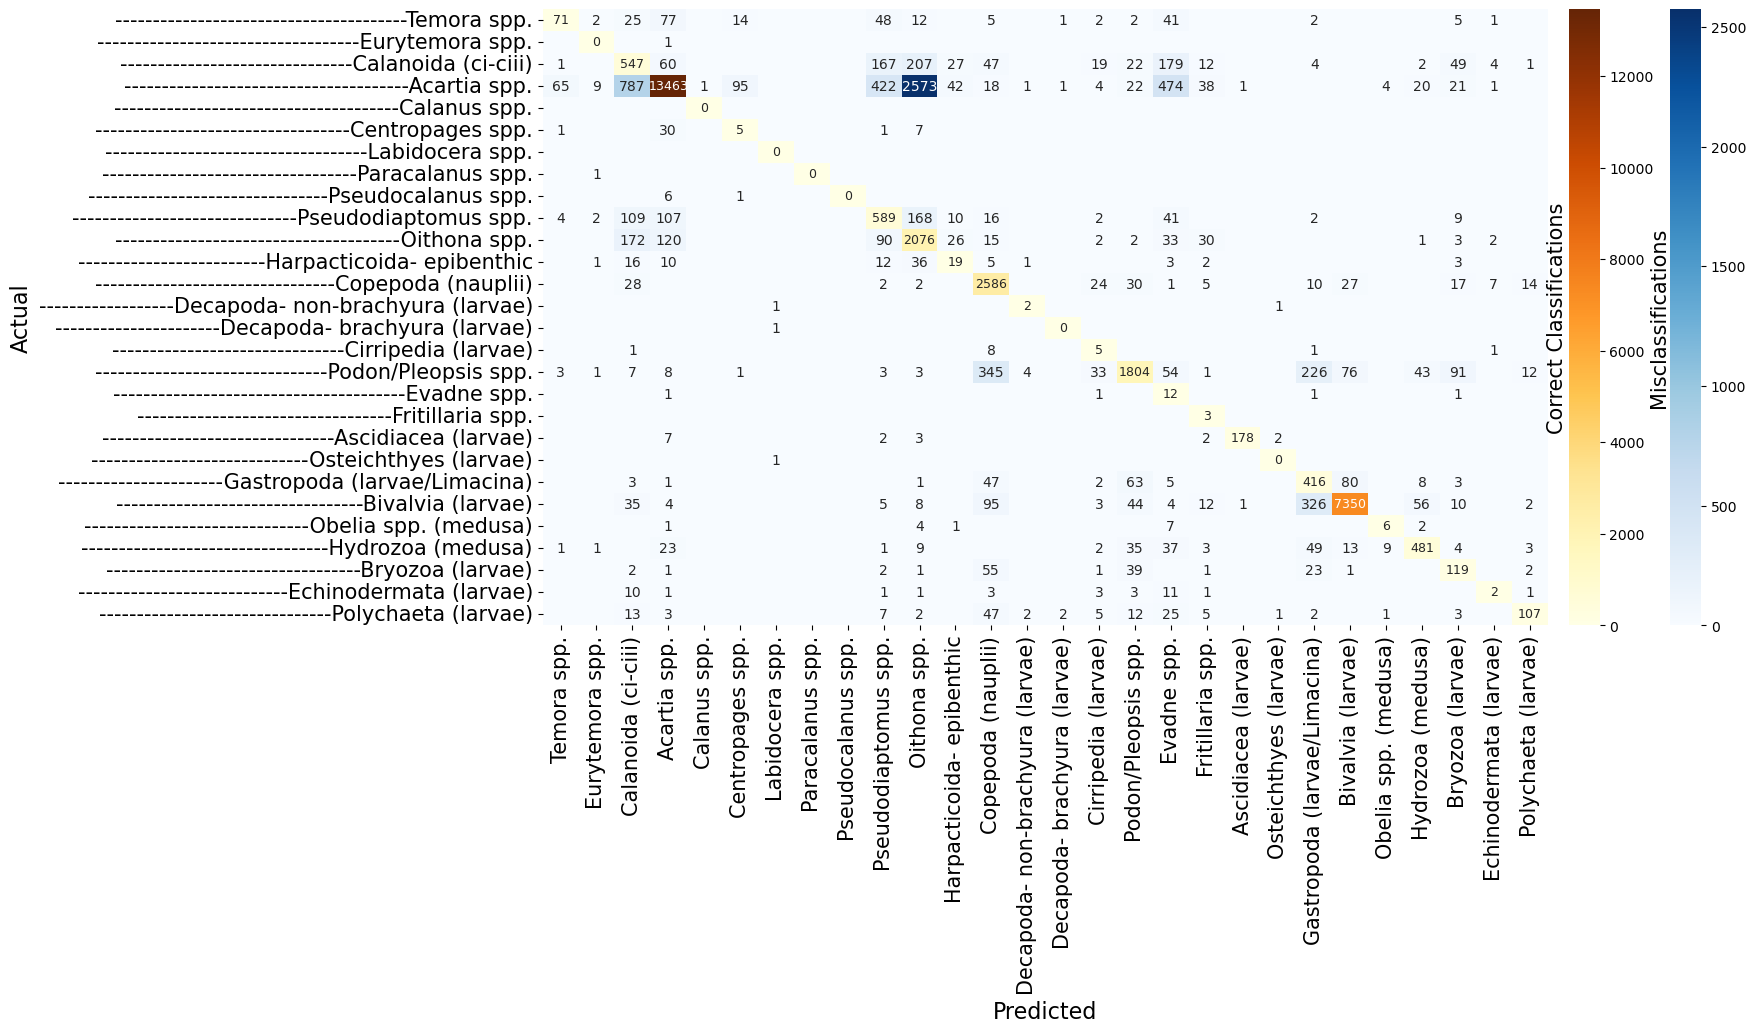

In [98]:
# CONFUSION MATRICES WITH COUNTS

cm_data = []
cm_names = []
regionYears = ml_df['regionYear'].unique()
print(regionYears)
for regionYear in regionYears:
    if regionYear != 'Gulf 2020':
        continue
    print(regionYear)
    regiondf = ml_df[ml_df['regionYear'] == regionYear]
    realNames = regiondf['object_newname'].to_numpy()
    predNames = regiondf['predicted_newName'].to_numpy()
    true_labels = realNames
    predicted_labels = predNames
    allNames = np.union1d(realNames, predNames)
    
    allNames = sorted(allNames, key=lambda x: order_from_r.index(x))
    
    print(f"# of species: {len(allNames)}")
    print(list(allNames))

        
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=allNames)
    print(np.shape(cm))
    cm_names.append(allNames)
    # diag_cm = cm.copy()
    cm_copy = cm.copy()
    cm_data.append(cm.copy())
    np.fill_diagonal(cm_copy, 0)
    # Display the confusion matrix
    cm_clipped = np.clip(cm_copy, a_min=None, a_max=10000)
    # cm[cm < 10] = 0
    # Replace the diagonal of cm1 with the diagonal of cm2
    # np.fill_diagonal(cm, np.diagonal(diag_cm))
    def annotate_heatmap(val):
        return f'{int(val)}' if val != 0 else ''
    plt.figure(figsize=(15, 8))


    # Create the mask for the diagonal
    mask = np.eye(len(cm), dtype=bool)
    

    intended_name_length = 50
    custom_cmap = sns.light_palette("seagreen", as_cmap=True)
    # Create the confusion matrix heatmap
    # ax = sns.heatmap(cm_clipped, annot=[[annotate_heatmap(val) for val in row] for row in cm], fmt="", cmap="Blues", xticklabels=allNames, yticklabels=allNames, norm=LogNorm(vmin=np.min(cm_clipped)+1, vmax=np.max(cm_clipped)))
    ax = sns.heatmap(cm, annot=[[annotate_heatmap(val) for val in row] for row in cm], fmt="", mask=mask, cmap="Blues", annot_kws={'size': 10}, cbar_kws={"fraction": 0.03, "pad": 0.06})
    
    plt.text(np.shape(cm)[0]+.27, np.shape(cm)[0]/2, 'Correct Classifications', rotation=90, fontsize=15, horizontalalignment='center', verticalalignment='center')
    plt.text(np.shape(cm)[0]+3.1, np.shape(cm)[0]/2, 'Misclassifications', rotation=90, fontsize=15, horizontalalignment='center', verticalalignment='center')
    
    # Overlay the diagonal with a different color scheme (e.g., 'Reds')
    sns.heatmap(cm, cmap='YlOrBr', fmt='.0f', annot_kws={'size': 9}, mask=~mask, cbar=True, annot=True, cbar_kws={"fraction": 0.03, "pad": 0.02})
    plt.xticks(ticks=np.arange(len(allNames)) + .5, labels=allNames, rotation=90, fontsize=15)
    plt.yticks(ticks=np.arange(len(allNames)) + .5, labels=[('-' * (intended_name_length - len(name))) + name for name in allNames], rotation=0, fontsize=15)
    # Display the plot
    plt.ylabel('Actual', fontsize=16)
    plt.xlabel('Predicted', fontsize=16)
    # plt.title(regionYear, fontsize=18)
    plt.savefig('testcm.png')
    plt.show()
    plt.close()


['Gulf 2020' 'PA 2021' 'NL 2020' 'NL 2021']
NL 2021
# of species: 24
['Temora spp.', 'Eurytemora spp.', 'Pseudocalanus spp.', 'Microcalanus spp.', 'Calanoida (ci-ciii)', 'Acartia spp.', 'Calanus spp.', 'Centropages spp.', 'Oithona spp.', 'Harpacticoida- epibenthic', 'Copepoda (nauplii)', 'Cirripedia (larvae)', 'Euphausiacea (nauplii)', 'Podon/Pleopsis spp.', 'Evadne spp.', 'Gastropoda (larvae/Limacina)', 'Bivalvia (larvae)', 'Oikopleura spp.', 'Fritillaria spp.', 'Bryozoa (larvae)', 'Chaetognatha', 'Echinodermata (larvae)', 'Obelia spp. (medusa)', 'Polychaeta (larvae)']


C:\Users\newblearbomb\AppData\Local\Temp\ipykernel_18704\3319611033.py:31: RuntimeWarning: invalid value encountered in divide
  perc_cm = np.where(row_sums == 0, 0, (cm / row_sums) * 100)


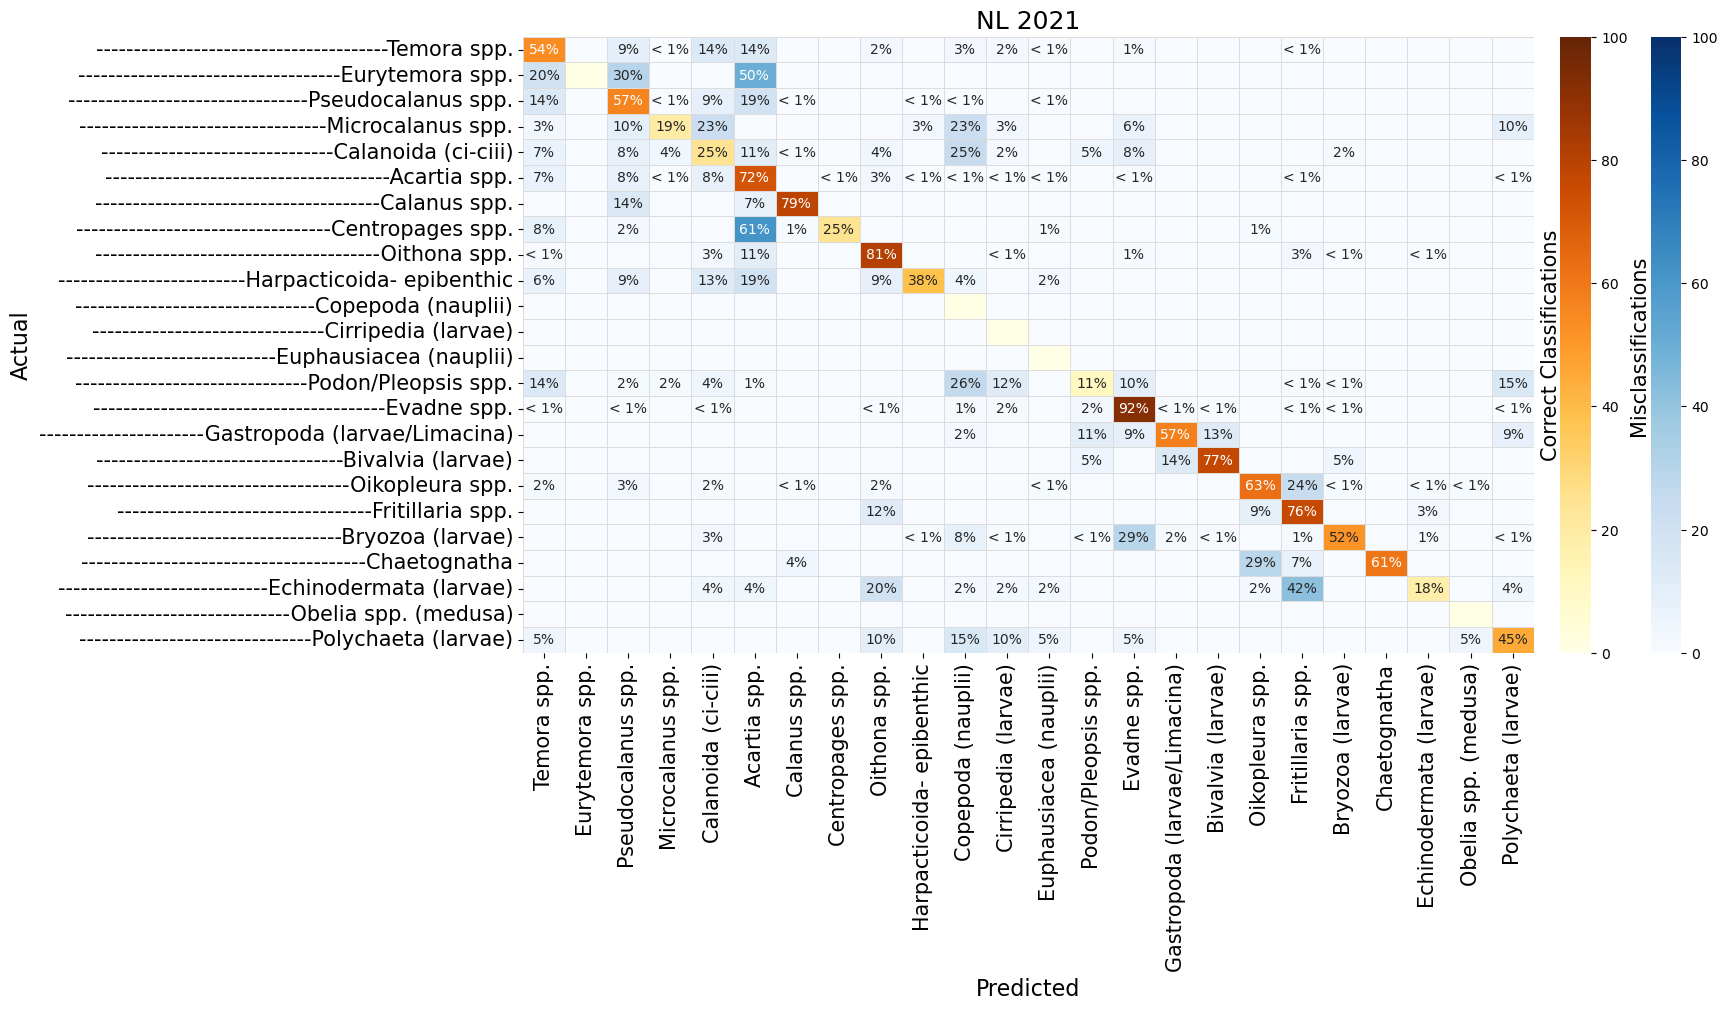

In [114]:
# CONFUSION MATRICES WITH ROW PERCENTAGES

cm_data = []
cm_names = []
regionYears = ml_df['regionYear'].unique()
print(regionYears)
for regionYear in regionYears:
    if regionYear != 'NL 2021':
        continue
    print(regionYear)
    regiondf = ml_df[ml_df['regionYear'] == regionYear]
    realNames = regiondf['object_newname'].to_numpy()
    predNames = regiondf['predicted_newName'].to_numpy()
    true_labels = realNames
    predicted_labels = predNames
    allNames = np.union1d(realNames, predNames)
    
    allNames = sorted(allNames, key=lambda x: order_from_r.index(x))
    
    print(f"# of species: {len(allNames)}")
    print(list(allNames))

        
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=allNames)
    cm_names.append(allNames)
    # diag_cm = cm.copy()
    cm_copy = cm.copy()
    cm_data.append(cm.copy())
    row_sums = cm.sum(axis=1, keepdims=True)  # Sum each row
    perc_cm = np.where(row_sums == 0, 0, (cm / row_sums) * 100)
    output_cm = np.empty_like(perc_cm, dtype=object)

    # Loop through the array and apply the condition
    for i in range(perc_cm.shape[0]):
        for j in range(perc_cm.shape[1]):
            if 0 < perc_cm[i, j] < 1:
                # print('changing to perc string')
                output_cm[i, j] = '< 1%'  # Set values between 0 and 1 to '< 1%'
            else:
                output_cm[i, j] = round(perc_cm[i, j])  # Round all other values

    def annotate_heatmap(val):
        if isinstance(val, str):
            return val
        elif val != 0:
            # print(val, type(val))
            return f"{round(val)}%"
        else:
            return ''

    plt.figure(figsize=(15, 8))

    # print(perc_cm)
    # Create the mask for the diagonal
    mask = np.eye(len(cm), dtype=bool)
    

    intended_name_length = 50
    custom_cmap = sns.light_palette("seagreen", as_cmap=True)
    # Create the confusion matrix heatmap
    ax = sns.heatmap(perc_cm, annot=[[annotate_heatmap(val) for val in row] for row in output_cm], fmt="", mask=mask, cmap="Blues", annot_kws={'size': 10}, cbar_kws={"fraction": 0.03, "pad": 0.05}, linewidths=0.5, linecolor='gainsboro', vmin=0, vmax=100)
    # Overlay the diagonal with a different color scheme (e.g., 'Reds')
    sns.heatmap(perc_cm, annot=[[annotate_heatmap(val) for val in row] for row in output_cm], cmap='YlOrBr', fmt='', annot_kws={'size': 10}, mask=~mask, cbar=True, cbar_kws={"fraction": 0.03, "pad": 0.025}, linewidths=0.5, linecolor='gainsboro', vmin=0, vmax=100)

    plt.text(np.shape(cm)[0]+.4, np.shape(cm)[0]/2, 'Correct Classifications', rotation=90, fontsize=15, horizontalalignment='center', verticalalignment='center')
    plt.text(np.shape(cm)[0]+2.5, np.shape(cm)[0]/2, 'Misclassifications', rotation=90, fontsize=15, horizontalalignment='center', verticalalignment='center')
    
    plt.xticks(ticks=np.arange(len(allNames)) + .5, labels=allNames, rotation=90, fontsize=15)
    plt.yticks(ticks=np.arange(len(allNames)) + .5, labels=[('-' * (intended_name_length - len(name))) + name for name in allNames], rotation=0, fontsize=15)
    # Display the plot
    plt.ylabel('Actual', fontsize=16)
    plt.xlabel('Predicted', fontsize=16)
    plt.title(regionYear, fontsize=18)
    plt.show()
    plt.close()
